In [167]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import time

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from tensorflow.keras.datasets import cifar10

## CIFAR-10 Data Loading and Preprocessing

In [168]:
# Load the raw CIFAR-10 data.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("X_train.shape = ", X_train.shape)
print("y_train.shape = ", y_train.shape)
print("X_test.shape = ", X_test.shape)
print("y_test.shape = ", y_test.shape)

X_train.shape =  (50000, 32, 32, 3)
y_train.shape =  (50000, 1)
X_test.shape =  (10000, 32, 32, 3)
y_test.shape =  (10000, 1)


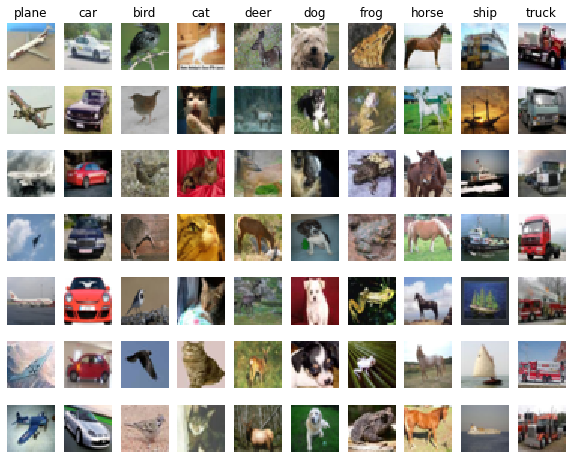

In [169]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [170]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000, 1)


In [171]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


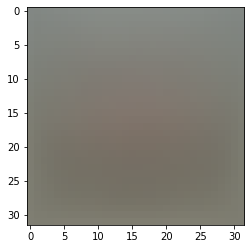

In [172]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [173]:
# second: subtract the mean image from train and test data
X_train = X_train - mean_image
X_val = X_val - mean_image
X_test = X_test - mean_image
X_dev = X_dev - mean_image

In [174]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

### 1. Tính hàm mất mát và đạo hàm của nó bằng cách naive

In [175]:
# naive way to calculate loss and grad
def svm_loss_naive(W, X, y, reg):
    d, C = W.shape 
    _, N = X.shape 
    
    ## naive loss and grad
    loss = 0 
    dW = np.zeros_like(W)
    for n in range(N):
        xn = X[:, n]
        score = W.T.dot(xn)
        for j in range(C):
            if j == y[n]:
                continue 
            margin = 1 - score[y[n]] + score[j]
            if margin > 0:
                loss += margin 
                dW[:, j] += xn 
                dW[:, y[n]] -= xn
    
    loss /= N 
    loss += 0.5*reg*np.sum(W * W) # regularization
    
    dW /= N 
    dW += reg*W # gradient off regularization 
    return loss, dW
    
# random, small data
N, C, d = 10, 3, 5
reg = .1 
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)

# sanity check
print('loss without regularization:', svm_loss_naive(W, X, y, 0)[0])
print('loss with regularization:', svm_loss_naive(W, X, y, 0.1)[0])

loss without regularization: 4.02447348361205
loss with regularization: 4.61813562572776


In [176]:
f = lambda W: svm_loss_naive(W, X, y, .1)[0]

# for checking if calculated grad is correct
def numerical_grad_general(W, f):
    eps = 1e-6
    g = np.zeros_like(W)
    # flatening variable -> 1d. Then we need 
    # only one for loop
    W_flattened = W.flatten()
    g_flattened = np.zeros_like(W_flattened)
    
    for i in range(W.size):
        W_p = W_flattened.copy()
        W_n = W_flattened.copy()
        W_p[i] += eps 
        W_n[i] -= eps 
        
        # back to shape of W 
        W_p = W_p.reshape(W.shape)
        W_n = W_n.reshape(W.shape)
        g_flattened[i] = (f(W_p) - f(W_n))/(2*eps)
        
    # convert back to original shape
    return g_flattened.reshape(W.shape) 

# compare two ways of computing gradient
g1 = svm_loss_naive(W, X, y, .1)[1]
g2 = numerical_grad_general(W, f)
print('gradient difference: %f' %np.linalg.norm(g1 - g2) )
# this should be very small

gradient difference: 0.000000


### 2. Tính hàm mất mát và đạo hàm của nó bằng cách vectorized

In [177]:
# more efficient way to compute loss and grad
def svm_loss_vectorized(W, X, y, reg):
    d, C = W.shape 
    _, N = X.shape 
    loss = 0 
    dW = np.zeros_like(W)
    
    Z = W.T.dot(X)     
    
    correct_class_score = np.choose(y, Z).reshape(N,1).T     
    margins = np.maximum(0, Z - correct_class_score + 1) 
    margins[y, np.arange(margins.shape[1])] = 0
    loss = np.sum(margins, axis = (0, 1))
    loss /= N 
    loss += 0.5 * reg * np.sum(W * W)
    
    F = (margins > 0).astype(int)
    F[y, np.arange(F.shape[1])] = np.sum(-F, axis = 0)
    dW = X.dot(F.T)/N + reg*W
    return loss, dW

In [178]:
N, C, d = 49000, 10, 3073
reg = .1 
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)

import time 
t1 = time.time()
l1, dW1 = svm_loss_naive(W, X, y, reg)
t2 = time.time()
print('Naive     : run time:', t2 - t1, '(s)')

t1 = time.time()
l2, dW2 = svm_loss_vectorized(W, X, y, reg)
t2 = time.time()
print('Vectorized: run time:', t2 - t1, '(s)')
print('loss difference:', np.linalg.norm(l1 - l2))
print('gradient difference:', np.linalg.norm(dW1 - dW2))

Naive     : run time: 31.967828512191772 (s)
Vectorized: run time: 0.3890221118927002 (s)
loss difference: 1.000444171950221e-11
gradient difference: 2.7089738852041666e-14


### 3. Gradient Descent cho Multi-class SVM

In [195]:
# Mini-batch gradient descent
def multiclass_svm_GD(X, y, Winit, reg, lr=0.01, batch_size = 100, num_iters = 3000, print_every = 100):
    W = Winit 
    loss_history = np.zeros((num_iters))
    for it in range(num_iters):
        # randomly pick a batch of X
        idx = np.random.choice(X.shape[1], batch_size)
        X_batch = X[:, idx]
        y_batch = y[idx]

        loss_history[it], dW = svm_loss_vectorized(W, X_batch, y_batch, reg)

        W -= lr*dW 
        if it % print_every == 1:
            print('it %d/%d, loss = %f' %(it, num_iters, loss_history[it]))

    return W, loss_history 

N, C, d = 49000, 10, 3073
reg = 0.1 
W = np.random.randn(d, C)
X = np.random.randn(d, N)
y = np.random.randint(C, size = N)

W, loss_history = multiclass_svm_GD(X, y, W, reg)

it 1/3000, loss = 1767.187405
it 101/3000, loss = 1511.319682
it 201/3000, loss = 1187.406956
it 301/3000, loss = 996.796217
it 401/3000, loss = 805.374897
it 501/3000, loss = 638.338339
it 601/3000, loss = 545.266961
it 701/3000, loss = 436.317361
it 801/3000, loss = 335.681786
it 901/3000, loss = 300.877000
it 1001/3000, loss = 232.165127
it 1101/3000, loss = 175.837982
it 1201/3000, loss = 145.522941
it 1301/3000, loss = 117.296780
it 1401/3000, loss = 95.279869
it 1501/3000, loss = 83.284476
it 1601/3000, loss = 59.659387
it 1701/3000, loss = 50.877081
it 1801/3000, loss = 41.931377
it 1901/3000, loss = 33.807268
it 2001/3000, loss = 25.782827
it 2101/3000, loss = 23.088798
it 2201/3000, loss = 18.316388
it 2301/3000, loss = 14.348782
it 2401/3000, loss = 13.717860
it 2501/3000, loss = 11.470123
it 2601/3000, loss = 10.697730
it 2701/3000, loss = 10.401473
it 2801/3000, loss = 11.713593
it 2901/3000, loss = 9.450384


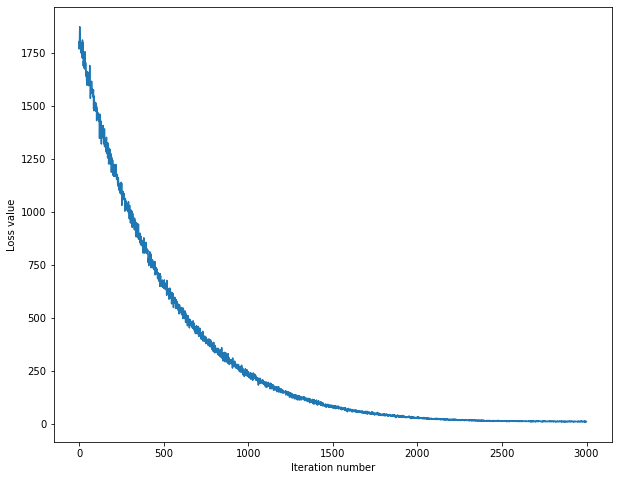

In [196]:
# plot loss as a function of iteration
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [197]:
def predict(X, W):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.
    Inputs:
    - X: D x N array of training data. Each column is a D-dimensional point.
    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    # pass
    scores = X.dot(W)
    y_pred = np.argmax(scores, axis = 1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred

In [198]:
y_pred = predict(X.T, W)
print('training accuracy: %f' % (np.mean(y == y_pred), ))

training accuracy: 0.220694


## Result